In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import Counter
from tqdm import tqdm
import numpy as np
import nltk
import gensim.downloader as api
import random
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Download the dataset if you haven't already
nltk.download('brown', quiet=True)
nltk.download('universal_tagset', quiet=True)

# Set a random seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Data Loading and Vocabulary Creation ---
corpus = nltk.corpus.brown.tagged_sents(tagset='universal')

all_words = [word.lower() for sent in corpus for word, tag in sent]
all_tags = [tag for sent in corpus for word, tag in sent]

word_counts = Counter(all_words)
tag_counts = Counter(all_tags)

word_to_idx = {word: i+2 for i, (word, _) in enumerate(word_counts.items())}
word_to_idx['<PAD>'] = 0
word_to_idx['<UNK>'] = 1

tag_to_idx = {tag: i+1 for i, (tag, _) in enumerate(tag_counts.items())}
tag_to_idx['<PAD>'] = 0

idx_to_tag = {i: tag for tag, i in tag_to_idx.items()}

# --- 2. Convert Sentences to Indices and Pad ---
sequences = []
for sent in corpus:
    word_indices = [word_to_idx.get(word.lower(), word_to_idx['<UNK>']) for word, tag in sent]
    tag_indices = [tag_to_idx[tag] for word, tag in sent]
    sequences.append((word_indices, tag_indices))

MAX_LEN = max(len(s) for s, t in sequences)
print(f"Maximum sentence length: {MAX_LEN}")

def pad_sequences(sequences, max_len, word_pad_idx, tag_pad_idx):
    padded_sents = []
    padded_tags = []
    for s, t in sequences:
        padded_s = s + [word_pad_idx] * (max_len - len(s))
        padded_t = t + [tag_pad_idx] * (max_len - len(t))
        padded_sents.append(padded_s)
        padded_tags.append(padded_t)
    return np.array(padded_sents), np.array(padded_tags)

padded_sents, padded_tags = pad_sequences(sequences, MAX_LEN, word_to_idx['<PAD>'], tag_to_idx['<PAD>'])

# --- 3. Train, Validation, Test Split ---
X_train, X_test, y_train, y_test = train_test_split(padded_sents, padded_tags, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED)

print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

# --- 4. Create PyTorch Dataset and DataLoader ---
class PosTaggingDataset(Dataset):
    def __init__(self, sentences, tags):
        self.sentences = torch.LongTensor(sentences)
        self.tags = torch.LongTensor(tags)

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.tags[idx]

train_dataset = PosTaggingDataset(X_train, y_train)
val_dataset = PosTaggingDataset(X_val, y_val)
test_dataset = PosTaggingDataset(X_test, y_test)

BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Using device: cpu
Maximum sentence length: 180
Train size: 41284
Validation size: 4588
Test size: 11468


### fastText

In [2]:
# --- Create Embedding Matrix from Pre-trained fastText ---
EMBEDDING_DIM = 300 # IMPORTANT: This must match the pre-trained model's dimension
print("Loading fastText model...")
ft_model = api.load("fasttext-wiki-news-subwords-300")
print("Model loaded.")

# Create the embedding matrix for our vocabulary
vocab_size = len(word_to_idx)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_to_idx.items():
    if word in ft_model:
        embedding_matrix[i] = ft_model[word]

embedding_matrix = torch.FloatTensor(embedding_matrix).to(device)
print("fastText embedding matrix created.")

Loading fastText model...
Model loaded.
fastText embedding matrix created.


### Architecture

In [9]:
# The from-scratch LSTM cell remains the same
class LSTMCell(nn.Module):
    """A from-scratch implementation of a single LSTM cell."""
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.linear_ih = nn.Linear(input_size, 4 * hidden_size)
        self.linear_hh = nn.Linear(hidden_size, 4 * hidden_size)

    def forward(self, x, states):
        h_prev, c_prev = states
        gates = self.linear_ih(x) + self.linear_hh(h_prev)
        i, f, g, o = gates.chunk(4, dim=1)
        
        i_t = torch.sigmoid(i)
        f_t = torch.sigmoid(f)
        g_t = torch.tanh(g)
        o_t = torch.sigmoid(o)
        
        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        
        return h_t, c_t

# --- RECTIFIED MODEL: BiLSTM Encoder + Linear Decoder ---
class BiLSTMPOSTagger(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx):
        super().__init__()
        
        # --- Encoder Part ---
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)
        self.embedding.weight.data.copy_(embedding_matrix)
        self.embedding.weight.requires_grad = True # Allow fine-tuning of embeddings
        
        # We build a BiLSTM from scratch using your LSTMCell
        self.lstm_cells_fwd = nn.ModuleList([
            LSTMCell(embedding_dim if i == 0 else hidden_dim, hidden_dim) 
            for i in range(n_layers)
        ])
        self.lstm_cells_bwd = nn.ModuleList([
            LSTMCell(embedding_dim if i == 0 else hidden_dim, hidden_dim) 
            for i in range(n_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        
        # --- Decoder Part ---
        # The decoder is a linear layer mapping hidden states to tag probabilities
        self.fc_out = nn.Linear(hidden_dim * 2, output_dim) # *2 for bidirectional
        
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

    def forward(self, src):
        # src: [batch_size, seq_len]
        batch_size, seq_len = src.shape
        
        # 1. ENCODING: Pass through embedding layer
        embedded = self.dropout(self.embedding(src))
        # embedded: [batch_size, seq_len, embedding_dim]
        
        input_seq = embedded.permute(1, 0, 2)
        # input_seq: [seq_len, batch_size, embedding_dim]

        # 2. ENCODING: Process with from-scratch BiLSTM
        
        # FORWARD PASS
        fwd_outputs = []
        h_fwd = [torch.zeros(batch_size, self.hidden_dim).to(device) for _ in range(self.n_layers)]
        c_fwd = [torch.zeros(batch_size, self.hidden_dim).to(device) for _ in range(self.n_layers)]

        for t in range(seq_len):
            input_t = input_seq[t]
            for i, layer in enumerate(self.lstm_cells_fwd):
                h_fwd[i], c_fwd[i] = layer(input_t, (h_fwd[i], c_fwd[i]))
                input_t = self.dropout(h_fwd[i]) if i < self.n_layers - 1 else h_fwd[i]
            fwd_outputs.append(h_fwd[-1])
            
        # BACKWARD PASS
        bwd_outputs = []
        h_bwd = [torch.zeros(batch_size, self.hidden_dim).to(device) for _ in range(self.n_layers)]
        c_bwd = [torch.zeros(batch_size, self.hidden_dim).to(device) for _ in range(self.n_layers)]

        for t in range(seq_len - 1, -1, -1):
            input_t = input_seq[t]
            for i, layer in enumerate(self.lstm_cells_bwd):
                h_bwd[i], c_bwd[i] = layer(input_t, (h_bwd[i], c_bwd[i]))
                input_t = self.dropout(h_bwd[i]) if i < self.n_layers - 1 else h_bwd[i]
            bwd_outputs.append(h_bwd[-1])
            
        bwd_outputs.reverse()
        
        # Combine encoder outputs
        fwd_outputs_tensor = torch.stack(fwd_outputs)
        bwd_outputs_tensor = torch.stack(bwd_outputs)
        lstm_outputs = torch.cat((fwd_outputs_tensor, bwd_outputs_tensor), dim=2)
        
        # 3. DECODING: Pass encoder outputs through the linear decoder
        predictions = self.fc_out(self.dropout(lstm_outputs))
        
        return predictions.permute(1, 0, 2)

### Training

Evaluating: 100%|██████████| 72/72 [00:10<00:00,  6.83it/s]



Epoch: 01 | Train Loss: 0.144 | Val. Loss: 0.077


Evaluating: 100%|██████████| 72/72 [00:12<00:00,  5.93it/s]



Epoch: 02 | Train Loss: 0.057 | Val. Loss: 0.073


Evaluating: 100%|██████████| 72/72 [00:09<00:00,  7.23it/s]



Epoch: 03 | Train Loss: 0.039 | Val. Loss: 0.074


Evaluating: 100%|██████████| 72/72 [00:11<00:00,  6.53it/s]



Epoch: 04 | Train Loss: 0.030 | Val. Loss: 0.078


Evaluating: 100%|██████████| 72/72 [00:16<00:00,  4.32it/s]



Epoch: 05 | Train Loss: 0.025 | Val. Loss: 0.082


Evaluating: 100%|██████████| 72/72 [00:13<00:00,  5.30it/s]



Epoch: 06 | Train Loss: 0.017 | Val. Loss: 0.083


Evaluating: 100%|██████████| 72/72 [00:13<00:00,  5.52it/s]



Epoch: 07 | Train Loss: 0.014 | Val. Loss: 0.085


Evaluating: 100%|██████████| 72/72 [00:13<00:00,  5.38it/s]



Epoch: 08 | Train Loss: 0.012 | Val. Loss: 0.087


Evaluating: 100%|██████████| 72/72 [00:10<00:00,  6.57it/s]



Epoch: 09 | Train Loss: 0.011 | Val. Loss: 0.087


Evaluating: 100%|██████████| 72/72 [00:11<00:00,  6.21it/s]



Epoch: 10 | Train Loss: 0.011 | Val. Loss: 0.088


Evaluating: 100%|██████████| 72/72 [00:13<00:00,  5.47it/s]



Epoch: 11 | Train Loss: 0.011 | Val. Loss: 0.088


Evaluating: 100%|██████████| 72/72 [00:09<00:00,  7.49it/s]



Epoch: 12 | Train Loss: 0.011 | Val. Loss: 0.088


Evaluating: 100%|██████████| 72/72 [00:13<00:00,  5.38it/s]



Epoch: 13 | Train Loss: 0.011 | Val. Loss: 0.088


Evaluating: 100%|██████████| 72/72 [00:11<00:00,  6.24it/s]



Epoch: 14 | Train Loss: 0.011 | Val. Loss: 0.088


Evaluating: 100%|██████████| 72/72 [00:11<00:00,  6.21it/s]



Epoch: 15 | Train Loss: 0.011 | Val. Loss: 0.088


Evaluating: 100%|██████████| 72/72 [00:10<00:00,  6.94it/s]



Epoch: 16 | Train Loss: 0.011 | Val. Loss: 0.088


Evaluating: 100%|██████████| 72/72 [00:10<00:00,  6.78it/s]



Epoch: 17 | Train Loss: 0.011 | Val. Loss: 0.088


Evaluating: 100%|██████████| 72/72 [00:10<00:00,  6.95it/s]



Epoch: 18 | Train Loss: 0.011 | Val. Loss: 0.088


Evaluating: 100%|██████████| 72/72 [00:09<00:00,  7.31it/s]



Epoch: 19 | Train Loss: 0.010 | Val. Loss: 0.088


Evaluating: 100%|██████████| 72/72 [00:10<00:00,  6.96it/s]



Epoch: 20 | Train Loss: 0.011 | Val. Loss: 0.088


Evaluating: 100%|██████████| 72/72 [00:11<00:00,  6.16it/s]



Epoch: 21 | Train Loss: 0.011 | Val. Loss: 0.088


Evaluating: 100%|██████████| 72/72 [00:11<00:00,  6.41it/s]



Epoch: 22 | Train Loss: 0.010 | Val. Loss: 0.088


Evaluating: 100%|██████████| 72/72 [00:12<00:00,  5.88it/s]



Epoch: 23 | Train Loss: 0.011 | Val. Loss: 0.088


Evaluating: 100%|██████████| 72/72 [00:10<00:00,  7.09it/s]



Epoch: 24 | Train Loss: 0.011 | Val. Loss: 0.088


Evaluating: 100%|██████████| 72/72 [00:10<00:00,  6.59it/s]



Epoch: 25 | Train Loss: 0.011 | Val. Loss: 0.088


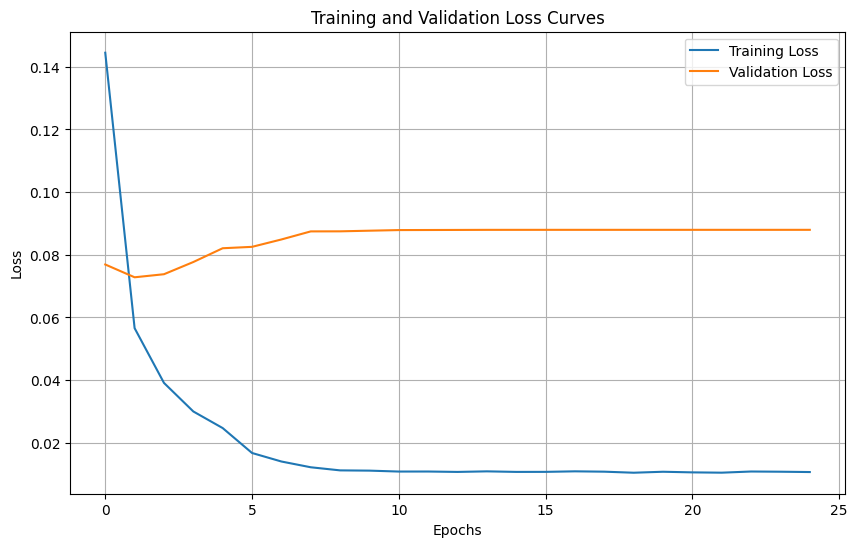


Best model was saved at Epoch 2 with validation loss: 0.0728


In [ ]:
# --- Hyperparameters ---
INPUT_DIM = len(word_to_idx)
OUTPUT_DIM = len(tag_to_idx)
EMBEDDING_DIM = 300       # From fastText
HIDDEN_DIM = 256
N_LAYERS = 1           # A 2-layer BiLSTM is a strong baseline
DROPOUT = 0.5             # Increased dropout for a more powerful model
WORD_PAD_IDX = word_to_idx['<PAD>']
TAG_PAD_IDX = tag_to_idx['<PAD>']
N_EPOCHS = 25

# --- Model, Loss, and Optimizer Initialization ---
model = BiLSTMPOSTagger(
    INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 
    N_LAYERS, DROPOUT, WORD_PAD_IDX
).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name and 'embedding' not in name:
            nn.init.xavier_uniform_(param.data)
        elif 'bias' in name:
            nn.init.constant_(param.data, 0)

model.apply(init_weights)

optimizer = optim.Adam(model.parameters())
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
criterion = nn.CrossEntropyLoss(ignore_index=TAG_PAD_IDX)

# --- Simplified Training and Evaluation Loops ---
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for src, trg in tqdm(iterator, desc="Training"):
        src, trg = src.to(device), trg.to(device)
        
        optimizer.zero_grad()
        
        # The forward pass now takes only the source sentence
        output = model(src)
        
        # CORRECTED THIS LINE: Use .reshape() instead of .view()
        output = output.reshape(-1, output.shape[-1])
        trg = trg.reshape(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for src, trg in tqdm(iterator, desc="Evaluating"):
            src, trg = src.to(device), trg.to(device)
            
            output = model(src)
            
            # CORRECTED THIS LINE: Use .reshape() instead of .view()
            output = output.reshape(-1, output.shape[-1])
            trg = trg.reshape(-1)
            
            loss = criterion(output, trg)
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)

# --- Start Training ---
best_valid_loss = float('inf')
train_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss = evaluate(model, val_loader, criterion)
    
    # Store losses for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    scheduler.step(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'pos-tagger-model-advanced.pt')
        
    print(f'\nEpoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Val. Loss: {valid_loss:.3f}')


# --- Plotting the Learning Curves ---
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Find the best epoch
best_epoch = np.argmin(valid_losses) + 1
print(f"\nBest model was saved at Epoch {best_epoch} with validation loss: {min(valid_losses):.4f}")

Testing: 100%|██████████| 180/180 [00:21<00:00,  8.28it/s]



--- Classification Report ---
              precision    recall  f1-score   support

         DET       0.98      0.97      0.98     27474
        NOUN       0.69      0.91      0.78     54822
         ADJ       0.68      0.32      0.44     16772
        VERB       0.78      0.78      0.78     36744
         ADP       0.93      0.91      0.92     28768
           .       1.00      1.00      1.00     29520
         ADV       0.76      0.40      0.53     11271
        CONJ       1.00      0.98      0.99      7529
         PRT       0.85      0.79      0.82      5853
        PRON       0.99      0.93      0.96      9934
         NUM       0.87      0.46      0.60      2911
           X       0.00      0.00      0.00       329

    accuracy                           0.84    231927
   macro avg       0.79      0.71      0.73    231927
weighted avg       0.84      0.84      0.83    231927



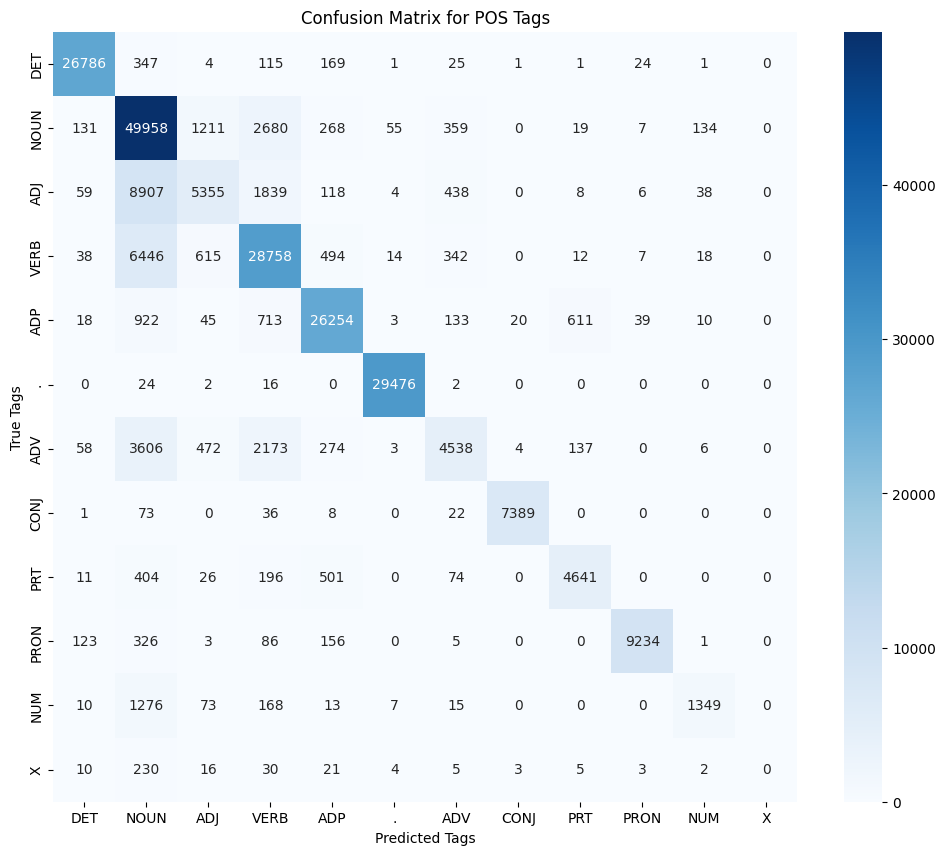


Example tagging for: 'the old man the boat'
[('the', 'DET'), ('old', 'NOUN'), ('man', 'NOUN'), ('the', 'DET'), ('boat', 'NOUN')]


In [ ]:
# Load the best model
model.load_state_dict(torch.load('pos-tagger-model-fixed.pt'))

def get_predictions(model, iterator, pad_idx):
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for src, trg in tqdm(iterator, desc="Testing"):
            src, trg = src.to(device), trg.to(device)
            
            output = model(src)
            preds = output.argmax(dim=2)
            
            for i in range(trg.shape[0]):
                true_len = (trg[i] != pad_idx).sum()
                true_tags_i = trg[i][:true_len].cpu().numpy()
                pred_tags_i = preds[i][:true_len].cpu().numpy()
                all_true.extend(true_tags_i)
                all_preds.extend(pred_tags_i)
                
    return all_true, all_preds

true_tags, pred_tags = get_predictions(model, test_loader, TAG_PAD_IDX)

# Convert indices back to tag names
true_labels = [idx_to_tag[t] for t in true_tags]
pred_labels = [idx_to_tag[p] for p in pred_tags]
tag_names = [tag for tag, i in tag_to_idx.items() if i != TAG_PAD_IDX]

# --- 1. Classification Report ---
report = classification_report(true_labels, pred_labels, labels=tag_names, zero_division=0)
print("\n--- Classification Report ---")
print(report)

# --- 2. Confusion Matrix ---
conf_matrix = confusion_matrix(true_labels, pred_labels, labels=tag_names)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=tag_names, yticklabels=tag_names)
plt.xlabel('Predicted Tags')
plt.ylabel('True Tags')
plt.title('Confusion Matrix for POS Tags')
plt.show()

# --- 3. Example Prediction Function (Updated) ---
def tag_sentence(sentence, model, word_to_idx, idx_to_tag, device, max_len):
    model.eval()
    tokens = [word.lower() for word in sentence.split(' ')]
    indices = [word_to_idx.get(token, word_to_idx['<UNK>']) for token in tokens]
    
    padded_indices = indices + [word_to_idx['<PAD>']] * (max_len - len(indices))
    src_tensor = torch.LongTensor(padded_indices).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(src_tensor)
    
    pred_indices = output.argmax(2).squeeze(0).cpu().numpy()
    pred_tags = [idx_to_tag[i] for i in pred_indices[:len(tokens)]]
    
    return list(zip(sentence.split(' '), pred_tags))

# Test a sentence
test_sentence = "the old man the boat"
tagged_sentence = tag_sentence(test_sentence, model, word_to_idx, idx_to_tag, device, MAX_LEN)
print(f"\nExample tagging for: '{test_sentence}'")
print(tagged_sentence)